In [1]:
import io
import os
import pickle
import random as rn
import warnings
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, \
        average_precision_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, GlorotUniform
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, \
        GlobalMaxPooling1D, SpatialDropout1D, LSTM, GRU, Flatten, MaxPooling1D, \
        BatchNormalization, ReLU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import models
import preprocessing

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Extracting the data

In [2]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [3]:
path_to_preprocessed_docs = "train/preprocessed_docs.pkl" # tokenization only
# path_to_preprocessed_docs = "train/preprocessed_docs_lemmatized_no_sw.pkl"

with open(path_to_preprocessed_docs, "rb") as f:
    preprocessed_train_docs = pickle.load(f)

# preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
# with open(path_to_preprocessed_docs, "wb") as f:
#     pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

Toronto stocks end higher after volatile session . CHANGE CHANGE TSE 5900.37 +50.15 HI 5900.37 LO 5840.29 DJI 6611.05 +27.57 GOLD ( LONDON ) US$ 350.00 +1.90 FTSE100 4248.10 -64.80 GOLD ( NY - COMEX ) US$ 354.80 +0.70 NIKKEI 17869.59 -133.81 LME CASH NICKEL US$ 7659 +99.0 CANDLR 1.3883 LME CASH ALUM US$ 1602.0 -4.0 CAN 30-YR 107.41 -0.15 BRENT CRUDE US$ 19.09 -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday , buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre - X Minerals hampered session * 84 million shares traded Toronto 's key stock index ended higher on Tuesday as the saga of Bre - X Minerals Ltd and its Indonesian gold find continued to dominate Canada 's biggest stock market . The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$ 1.4 billion . But the overall market was mixed with declining issues narrowly outpacing advances 476

## Representing the documents as token index sequences

In [4]:
docs = preprocessed_train_docs
n_vocabulary = 20000

In [5]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="", lower=False)
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index
if n_vocabulary is None:
    n_vocabulary = len(word_idx)

print(n_vocabulary)

20000


In [6]:
n_sequence = 256

sequences = tokenizer.texts_to_sequences(docs)
if n_sequence is None:
    n_sequence = max([len(s) for s in sequences])
sequence_lengths = [min(len(s), n_sequence) for s in sequences]
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2][:100])

256
(299773, 256)
[ 2112   217   137   145    52  2639   593     2  3714  3714  9473  8514
  9051  4802    14  2981    13   587  4802    14  3274     7  3355    13
   587 15304  1660  5594 16940   587  1660  5594   587 14783  1709 11671
 15729 13077   587    38  2112   217   226   145    12    85     3  5774
    23  1043     6 11672     9   809    38  3318   700   167     4   901
   181     6  3495     7  1927  6603  9271   593    38  4214    31    75
   418  2112    15   435   150   180   226   145    12    85    30     1
 15801     5  3495     7  1927  6603   200     9    32  1780   441  1151
   598     4  7599   622]


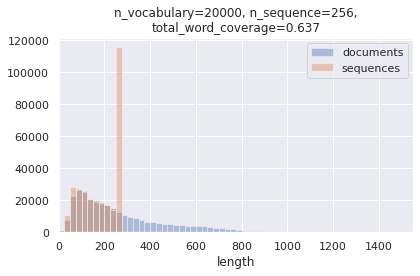

In [7]:
doc_lengths = [len(doc.split()) for doc in docs]

sns.distplot(doc_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="documents")
sns.distplot(sequence_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="sequences")
total_word_coverage = np.round(np.sum(sequence_lengths) / np.sum(doc_lengths), 3)
plt.title(f"n_vocabulary={n_vocabulary}, n_sequence={n_sequence},\n"
          f"total_word_coverage={total_word_coverage}")
plt.xlim(0, 1550)
plt.xlabel("length")
plt.legend()
plt.tight_layout()
plt.show()

## Word embeddings

In [8]:
n_embedding = 300 # 300 required by FastText

### Word2Vec

In [9]:
reset_seed()

window = 5
w2v_path = f"data/w2v_{window}_{n_embedding}.model"

try:
    w2v_embedding_model = Word2Vec.load(w2v_path)
except:
    w2v_embedding_model = Word2Vec(sentences=[s.split() for s in docs],
                                   size=n_embedding, 
                                   window=window,
                                   min_count=5,
                                   sg=1,
                                   workers=cpu_count(),
                                   seed=seed)
    w2v_embedding_model.save(w2v_path)

print(len(list(w2v_embedding_model.wv.vocab)))
print(w2v_embedding_model.wv.index2entity[:100])

191252
['the', '.', ',', 'to', 'of', 'in', '-', 'a', 'and', '"', 'said', 'on', ')', '(', "'s", 'for', 'The', 'at', 'was', '$', 'that', 'is', 'by', 'with', 'from', 'percent', 'it', 'be', '/', 'as', 'million', 'its', 'will', 'has', '--', 'were', 'not', '*', 'would', 'year', 'are', 'have', 'an', 'he', 'which', ':', 'had', 'market', 'up', 'A', 'but', 'after', 'N', 'this', 'company', 'one', 'been', 'U.S.', 'billion', 'also', 'government', 'last', 'or', '1997', 'two', 'their', 'they', 'first', 'over', 'new', '1', 'his', 'more', 'June', 'shares', 'about', 'week', 'It', 'than', 'share', 'Bank', 'who', 'I', '1996', 'Tuesday', '%', 'per', 'Wednesday', 'May', 'we', 'expected', 'July', 'Thursday', 'Monday', 'We', 'some', 'Friday', 'down', 'could', 'three']


### FastText

In [ ]:
def load_vectors(fname): # from https://fasttext.cc/docs/en/english-vectors.html
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

ft_embedding_model = load_vectors("data/crawl-300d-2M.vec")

token_iter = iter(ft_embedding_model)
print([next(token_iter) for i in range(100)])

### Embedding matrices

In [ ]:
def create_embedding_matrix(embedding_model):
    embedding_matrix = np.zeros((n_vocabulary, n_embedding))
    unknown_token_count = 0
    for token, i in word_idx.items():
        if i >= n_vocabulary:
            continue
        if token in embedding_model:
            embedding_matrix[i] = embedding_model[token]
        else:
            embedding_matrix[i] = np.zeros(n_embedding)
            unknown_token_count += 1

    print(unknown_token_count)
    print(embedding_matrix.shape)
    print(embedding_matrix[1][:50])

    return embedding_matrix

In [ ]:
w2v_embedding_matrix = create_embedding_matrix(w2v_embedding_model)

In [ ]:
ft_embedding_matrix = create_embedding_matrix(ft_embedding_model)

## Shuffling the data

In [ ]:
n_samples = None
x_train, y_train = shuffle(sequences,
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)

## Cross-evaluating the models

In [ ]:
def cross_evaluate(model_initializer, embedding_matrix, loss, batch_size=256):
    kfold = KFold(n_splits=5)
    cv_scores = []

    model_initializer(embedding_matrix, n_vocabulary, n_embedding, n_sequence,
                      n_labels, loss).summary()

    for train, val in kfold.split(x_train, y_train):
        model = model_initializer(embedding_matrix, n_vocabulary, n_embedding,
                                  n_sequence, n_labels, loss)
        es = EarlyStopping(patience=3, verbose=1, restore_best_weights=True)
        history = model.fit(x_train[train],
                            y_train[train],
                            batch_size=batch_size,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_train[val], y_train[val]),
                            callbacks=[es])

        y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
        y_pred = np.round(y_pred_prob)

        scores = {}
        scores["accuracy"] = accuracy_score(y_train[val], y_pred)
        scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
        scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
        scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                               y_pred_prob)
        scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
        cv_scores.append(scores)
        print(scores)

    cv_scores_df = pd.DataFrame(cv_scores)
    display(cv_scores_df)
    print(cv_scores_df.mean())

In [16]:
reset_seed()
cross_evaluate(models.init_cnn_1, ft_embedding_matrix, "mean_squared_error")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
937/937 [==============================] - 19s 20ms/step - loss: 0.0124 - val_loss: 0.0073
Epoch 2/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 3/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 4/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 5/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 6/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 7/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 9/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0042 - val_loss: 0.0046

Epoch 3/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 4/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 5/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 6/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 7/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 8/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 9/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 10/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 11/100
937/937 [==============================] - 17s 18ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 12/100
937/937 [==============================] - 17s 18ms/step -

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.683846,0.584922,0.888718,0.952477,0.972806
1,0.679643,0.575897,0.887256,0.951123,0.972017
2,0.684063,0.579400,0.888374,0.953059,0.973266
3,0.683107,0.582903,0.888007,0.951833,0.972293
4,0.677503,0.574416,0.885217,0.950426,0.971992


accuracy      0.681632
F1 (macro)    0.579508
F1 (micro)    0.887515
LRAP          0.951784
NDCG          0.972475
dtype: float64


In [18]:
reset_seed()
cross_evaluate(models.init_cnn_2, ft_embedding_matrix, "mean_squared_error")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 300)          6000000   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 255, 200)          120200    
_________________________________________________________________
batch_normalization_20 (Batc (None, 255, 200)          800       
_________________________________________________________________
re_lu_20 (ReLU)              (None, 255, 200)          0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 127, 200)          0         
_______

Epoch 6/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 7/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 8/100
937/937 [==============================] - 16s 17ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/100
937/937 [==============================] - 16s 17ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 10/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 11/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 12/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 13/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 14/100
937/937 [==============================] - 16s 17ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 15/100
937/937 [==============================] - 16s 17ms/ste

Epoch 12/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 13/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 14/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 15/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 16/100
937/937 [==============================] - 16s 18ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 00016: early stopping
235/235 [==============================] - 1s 4ms/step
{'accuracy': 0.6761517163158421, 'F1 (macro)': 0.5738946606389751, 'F1 (micro)': 0.8849443477470396, 'LRAP': 0.9502768389395798, 'NDCG': 0.9719593545197298}


,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.684714,0.584286,0.888041,0.952702,0.972752
1,0.680794,0.576147,0.886403,0.951883,0.972240
2,0.686648,0.580900,0.888736,0.952893,0.973217
3,0.682206,0.572390,0.886658,0.951529,0.972051
4,0.676152,0.573895,0.884944,0.950277,0.971959


accuracy      0.682103
F1 (macro)    0.577523
F1 (micro)    0.886956
LRAP          0.951857
NDCG          0.972444
dtype: float64


In [ ]:
reset_seed()
cross_evaluate(models.init_cnn_lstm_2, ft_embedding_matrix, "binary_crossentropy")